# BRIEF SUMMARY

There is a large amount of data available related to the NBA seasons (prefessional basketball). After the introduction of SportVU cameras in every stadium, we now have the ability to know exactly where all five offensive players and all five defensive players are at every moment of the game. We also know where every shot is taken. 

I am interested in understanding where the top players are shooting from. More specifically, I am interested in the spatial distribution of shots taken by each player.

# INTRODUCTION

## Background

There is a large amount of data available related to the NBA seasons (prefessional basketball). After the introduction of SportVU cameras in every stadium, we now have the ability to know exactly where all five offensive players and all five defensive players are at every moment of the game.

We also know where every shot is taken. I am interested in understanding where the top players are shooting from. More specifically, I am interested in the spatial distribution of shots taken by each player.

# LOADING and CLEANING DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import radar_plot
import sklearn.model_selection
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics


C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Let's load the data from the 2013-14 season that I downloaded from https://github.com/hwchase17/sportvu.

I will also remove any unwanted columns and add a column (the shooter's team).

In [2]:
# Load data and keep desired columns
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
full_DatFrame[:5]

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0


In [3]:
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])

# Add shooter's team column
teamID_dict = plot_court.out_teamsDict()
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']
df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)

## Discretizing the court for binning

Before I start analyzing the data, I must decide how I want to describe each player's spatial distribution of shots.

Instead of just analyzing the raw data, I wanted to use a model to estimate the underlying shot distribution that best describes the outcome. The raw data is sparse and there are a number of locations where a player did not take from. However, just because the player did not shoot from there over the course of the season does not mean that the probability of shooting from that location is zero. A model allows me to smoothen the shot distribution and have non-zero values for locations where no shots were taken (due to sparse sampling).

It is reasonable to model the spatial location of each shot attempt using an inhomogeneous Poisson point process. The Poisson point process is a commonly used statistical model of randomly located points in space. This will help us estimate the average number of expected shots (not an integer) from each location.

------------------------------------------------------------------------

To simplify the problem, I will grid up the court into small boxes and estimate the number of shots in the region defined by the box.

A finer grid is ideal. It will give me a better resolution of the shot distribution. However, a finer grid also requires more computation time to fit the model.

I settled on 25 horizontal rows (along x-axis) and 18 vertical columns (along y-axis). This corresponds to bins that are 2x2 feet areas on the court.

In [4]:
# Number of bins and range in each direction used to make the grid for analysis
bins, binRange = ([25,18], [[-250,250], [-47.5,312.5]])

hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(df.LOC_X, df.LOC_Y, 
                                                                    df.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=bins, 
                                                                    range=binRange)
# Creating the grid we will use for analysis
XX, YY = np.meshgrid(xedges, yedges)
binX_flat = XX.T[:-1,:-1].flatten()
binY_flat = YY.T[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

## Creating training data for players

Let's create a list of the top 300 players in most shots taken during the 2013-14 season.

In [5]:
num_players = 300
top_players_shotNum = df.PLAYER_NAME.value_counts()[:num_players]
top_players_nameList = top_players_shotNum.index.tolist()

Now that I know which players I am including in my study, I want to create a training set for each player. 80% of each of these players' shots are added to the training set, and the other shots are added to a testing set.

We can use the testing set to verify our conclusions later.

In [6]:
train_df = {}
test_df = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = df[df.PLAYER_NAME == player]
    train_df[player], test_df[player] = sklearn.model_selection.train_test_split(temp, test_size = 0.2)

    
player_shotHist_train = {}
for i, player in enumerate(set(top_players_nameList)):  
    temp = train_df[player]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=bins, 
                                                                        range=binRange)
    player_shotHist_train[player] = hist2d.flatten()

# LOG-GAUSSIAN COX PROCESS (LGCP) MODEL

## Theory behind the model

As mentioned previously, the spatial location of each shot attempt using an inhomogeneous Poisson point process. 

For each player ($n$), I need to infer the expected number of shots ($\lambda_{n,v}$) taken from each grid point ($v$) on the discretized court. From that, we can get each player's shot profile ($\mathbf{\lambda_n} = [\lambda_{n,1} \dots \lambda_{n,V}]^T$), where $V$ is the number of grid points.

Since we don't know $\mathbf{\lambda_n}$, we will estimate it using likelihood-maximization. 

------------------------------------------

Let's first start by defining some variables, how we obtain them, and how we will use them.

The data we imported and cleaned gives us a count of the number of shots ($X_{n,v}$) in each bin ($v$) for each player ($n$). This player data can be summarized by a flattened 2-dimensional histogram: $\mathbf{x_n} = [X_{n,1} \dots X_{n,V}]^T$.

For a given player shot profile ($\mathbf{\lambda_n}$), the likelihood we see the observed data ($\mathbf{x_n}$) follows a Poisson process:

> ${\displaystyle p(\mathbf{x_n}|\mathbf{\lambda_n}) = \prod_{v=1}^V p(X_{n,v}|\lambda_{n,v}) }$

> ${\displaystyle p(X_{n,v}|\lambda_{n,v}) = e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

where $p(X_{n,v}|\lambda_{n,v})$ is the probability that $X_{n,v}$ shots are taken in area $v$ given that the expected number is $\lambda_{n,v}$. The above equation assumes that each shot is independent.

-----------------------------------------

However, what we are really interested in is the shot profile that maximizes the likelihood of seeing the data. To do this, we turn to Bayes' theorem.

The likelihood of a given shot profile ($\mathbf{\lambda_n}$) explaining the observed data is

> ${\displaystyle p(\mathbf{\lambda_n}|\mathbf{x_n}) \propto p(\mathbf{x_n}|\mathbf{\lambda_n}) p(\mathbf{\lambda_n}) }$

The $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ will gives us the best estimate of each player's shot profile. I already showed how to compute $p(\mathbf{x_n}|\mathbf{\lambda_n})$, but how to compute $p(\mathbf{\lambda_n})$ is less clear.

--------------------------------------------------------

The prior ($p(\mathbf{\lambda_n})$) describes how confident I am in what $\mathbf{\lambda_n}$ should be.

We could set $p(\mathbf{\lambda_n})$ to a constant, which says all values of $\mathbf{\lambda_n}$ are equally likely. For this case, the $\mathbf{\lambda_n}$ that maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$ is simply $\mathbf{\lambda_n} = \mathbf{x_n}$. This is the frequentist approach which is the same as using the raw data instead of fitting a model. This has two undesired properties:

1. $\lambda_{n,v}=0$ in areas where a player didn't shoot from. But just because a player didn't shoot from a certain bin during the season doesn't mean the probability of him shooting from there is zero.

2. $\lambda_{n,v}$ and $\lambda_{n,v'}$ are not correlated, even if bins $v$ and $v'$ are nearby. I don't expect that a player's shooting behavior changes drastically just a few feet away. 

----------------------------------------------------

To solve both issues, we define $p(\mathbf{\lambda_n})$ as

> ${\displaystyle p(\mathbf{\lambda_n}) = p(\mathbf{z_n}) = \mathcal{N}(\mathbf{z_n}|0,\mathbf{K}) }$

> ${\displaystyle \mathbf{\lambda_n} = \exp(z_0 + \mathbf{z_n}) }$

where $z_0$ is a bias term and $\mathcal{N}(\mathbf{z_n}|0,\mathbf{K})$ is a normal distribution over a field variable $\mathbf{z_n}$ with a zero mean and a covariance $\mathbf{K}$.

The covariance matrix ($\mathbf{K}$) captures the correlations between neighboring bins. The closer the bins are, the larger the pair correlation. A simple way to capture this is to use an isotropic function to describe the correlations so they are only a function of the distance between bins (and not whether the bins are left, right, etc. of each other). In this work, $\mathbf{K}$ has elements $K_{i,j}$, where

> ${\displaystyle K_{i,j} = \sigma^2 \exp \left( - \frac{d_{i,j}^2}{2 \phi^2} \right) }$

$d_{i,j}$ is the distance between bins $i$ and $j$, $\phi$ is a length scale, and $\sigma^2$ is the marginal variation. Since $d_{i,j} = d_{j,i}$, $\mathbf{K}$ is a symmetric matrix.

As mentioned previously, the correlation matrix makes $\lambda_{n,v}$ vary smoothly. Bins where a player didn't take shots from will have estimates that are similar to neighboring bins.

-------------------------------------------------


In [7]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)

def cov_func(dist_matrix, sigma2, phi2):
    return sigma2 * np.exp( -(dist_matrix**2) / (2 * phi2) )

I use a large $\sigma^2$ to show that we are not very certain about our inital guess of $\z_{n,v} = 0$ for all bins $v$.

I also set $\phi$ to be 2.5 feet. I just chose this value because it seemed reasonable.

In [8]:
sigma2 = 60.
phi2 = 25.**2

cov_K = cov_func(dist_matrix, sigma2, phi2)
det_cov_K = np.linalg.det(cov_K)
inv_cov_K = np.linalg.inv(cov_K)

## Putting the model into Python

The $\mathbf{\lambda_n}$ that maximizes $\ln p(\mathbf{\lambda_n}|\mathbf{x_n})$ also maximizes $p(\mathbf{\lambda_n}|\mathbf{x_n})$. This is convenient because maximizing $\ln [p(\mathbf{\lambda_n}|\mathbf{x_n}) ]$ is computationally cheaper.

So we define the following functions:

---------

The first is the logarithm of the prior distribution ($\ln p(\mathbf{\lambda_n})$)

> ${\displaystyle p(\mathbf{\lambda_n}) = \frac{1}{2 \pi \sqrt{det(\mathbf{K})}} \exp \left( -\frac{1}{2} \mathbf{z_n}^T \mathbf{K} \mathbf{z_n} \right) }$

In [9]:
def ln_prior(zn_v, det_cov_K, inv_cov_K):
    part1 = -np.log(2 * np.pi * (det_cov_K**0.5))
    part2 = -0.5 * np.dot(zn_v, np.dot(inv_cov_K, zn_v))
    return part1 + part2

Then we define the player shot profile ($\mathbf{\lambda_n}$) and how it depends on the field variables ($z_0$ and $\mathbf{z_n}$).

> $\mathbf{\lambda_n} = \exp(z_0 + \mathbf{z_n})$

In [10]:
def lambdaN_func(z0, zn_v):
    return np.exp(z0 + zn_v)

def ln_lambdaN_func(z0, zn_v):
    return z0 + zn_v

Then we define the likelihood that we observe the data ($p(\mathbf{x_n}|z_0, \mathbf{z_n})$)

> ${\displaystyle p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \prod_{v=1}^V e^{-\lambda_{n,v}} \frac{\lambda_{n,v}^{X_{n,v}}}{X_{n,v}!} }$

> ${\displaystyle \ln p(\mathbf{x_n}|z_0, \mathbf{z_n}) = \sum_{v=1}^V \left[ -\lambda_{n,v} + X_{n,v} \ln \lambda_{n,v} - \ln(X_{n,v}!) \right] }$

where $\ln(X_{n,v}!)$ is estimated using an equation given by Srinivasa Ramanujan (Ramanujan 1988).

In [11]:
def ln_factorial(n):
    # an improvement of the Sterling Approximation of log(n!)
    # given by Srinivasa Ramanujan (Ramanujan 1988)
    # scipy.misc.factorial stops worknig at large values of n
    sterling = n * np.log(n) - n
    correct = (1./6) * np.log(n * (1 + 4*n*(1 + 2*n))) + np.log(np.pi)/2
    return sterling + correct

def ln_likelihood(z0, zn_v, Xn_v):
    part1 = -lambdaN_func(z0, zn_v)
    part2 = Xn_v * ln_lambdaN_func(z0, zn_v)
    part3 = np.nan_to_num(-ln_factorial(Xn_v))
    #print(np.sum(part1), np.sum(part2), np.sum(part3))
    #print(part3)
    return np.sum(part1 + part2 + part3)

Finally, the posterior probability ($p(\mathbf{\lambda_n}|\mathbf{x_n})$) is

> $p(\mathbf{\lambda_n}|\mathbf{x_n}) = \mathrm{const} \times p(\mathbf{x_n}|\mathbf{\lambda_n}) p(\mathbf{\lambda_n})$

> $\ln p(\mathbf{\lambda_n}|\mathbf{x_n}) = \ln(\mathrm{const}) + \ln p(\mathbf{x_n}|\mathbf{\lambda_n}) + \ln p(\mathbf{\lambda_n})$

In [12]:
def ln_postprob(z, Xn_v, det_cov_K, inv_cov_K):
    z0 = z[0]
    zn_v = z[1:]
    return ln_prior(zn_v, det_cov_K, inv_cov_K) + ln_likelihood(z0, zn_v, Xn_v)

We then normalize $\mathbf{\lambda_n}$ such that $\sum_{v=1}^{V} \bar{\lambda}_{n,v} = 1$

> ${\displaystyle \mathbf{\bar{\lambda}_n} = \frac{ \mathbf{\lambda_n} }{ \sum_{v=1}^{V} \lambda_{n,v} } }$

To overlay the player's shot profile over the court, I define the following function:

In [13]:
def plot_player_normLambda(player, norm_lambdaN_v, vmax=None):
    LAMBDA_v = np.reshape(norm_lambdaN_v, bins)
    ##########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(LAMBDA_v.T, cmap=plt.cm.hot_r, alpha=.9, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: LGCP'%(player), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_player_Xn(player, Xn_v, vmax=None):
    Xn_2d = np.reshape(Xn_v, bins)
    #########
    extent = np.min(xedges), np.max(xedges), np.max(yedges), np.min(yedges)
    
    plt.imshow(Xn_2d.T, cmap=plt.cm.hot_r, alpha=.9, vmax=vmax,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: histogram of data'%(player), fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Testing the model on a player

To verify that our model is working in Python, we will apply it to one of the star players in the NBA: Kevin Durant.

In [14]:
player = 'Kevin Durant'
#################################################
Xn_v = player_shotHist_train[player]
z0_guess = np.log(np.mean(Xn_v))
zn_v_guess = np.zeros(len(Xn_v))
z_guess = np.append(z0_guess, zn_v_guess)

neg_logLike = lambda *args: -ln_postprob(*args)
result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                 args=(Xn_v, det_cov_K, inv_cov_K))
z_MaxLike = result["x"]
z0_MaxLike = z_MaxLike[0]
zn_MaxLike = z_MaxLike[1:]
lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)

C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Geoff\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
C:\Users\Geoff\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


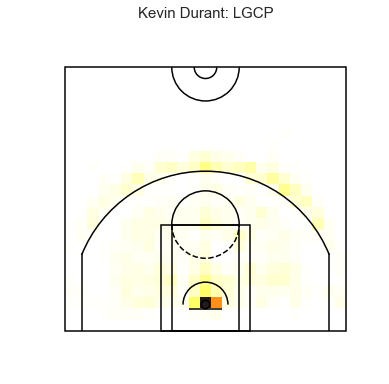

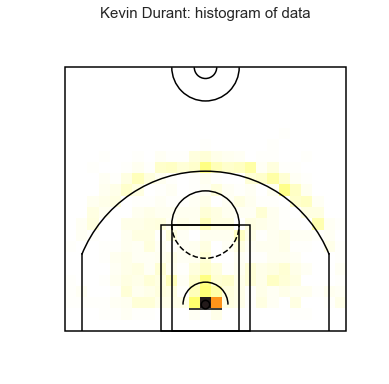

In [15]:
plot_player_normLambda(player, norm_lambdaN_v)
plot_player_Xn(player, Xn_v)

# EXTRACTING the COMPONENTS of PLAYER PROFILES

## Brief overview of Non-negative Matrix Factorization (NMF)

Now that we have 100 player shot profiles, I thought it would be interesting to describe each player's shot profile as a linear combination of different components. This would help me simply but quantitatively describe and compare different players. 

This kind of dimensionality reduction is often done using principle component analysis (PCA). However, PCA would allow weights and elements of the components to be negative. Non-negative matrix factorization does something similar, but it also ensures that all weights and values of the components are zero or positive. This makes the components easy to interpret.

You probably noticed that computing $\mathbf{\lambda_n}$ for each player takes some time, so I ran the results for the top 100 players in shots taken and saved it in the "player_lambda" directory.

We then store it in the matrix $\mathbf{\Lambda} = [\mathbf{\bar{\lambda}_1} \dots \mathbf{\bar{\lambda}_{100}}]^T$.

In [16]:
LL = np.zeros((num_players,np.prod(bins)))
for i, player in enumerate(top_players_nameList):
    try:
        norm_lambdaN_v = np.loadtxt('player_lambda/norm_lambda_%s.txt'%(player))
    except:
        Xn_v = player_shotHist_train[player]
        z0_guess = np.log(np.mean(Xn_v))
        zn_v_guess = np.zeros(len(Xn_v))
        z_guess = np.append(z0_guess, zn_v_guess)
    
        neg_logLike = lambda *args: -ln_postprob(*args)
        result = scipy.optimize.minimize(neg_logLike, z_guess, 
                                         args=(Xn_v, det_cov_K, inv_cov_K))
        z_MaxLike = result["x"]
        z0_MaxLike = z_MaxLike[0]
        zn_MaxLike = z_MaxLike[1:]
        lambdaN_v = np.exp(z0_MaxLike + zn_MaxLike)
        norm_lambdaN_v = lambdaN_v / np.sum(lambdaN_v)
    
        np.savetxt('player_lambda/norm_lambda_%s.txt'%(player), norm_lambdaN_v)
    LL[i,:] = norm_lambdaN_v[:]

I then I compute the weights ($\mathbf{W}$) and components ($\mathbf{H}$) matrices that approximate $\mathbf{\Lambda}$: 

> $\mathbf{\Lambda} \approx \mathbf{W} \mathbf{H}$

I choose the number of components to be 10. I chose this number to see subtle differences between different kinds of shots. For example, we can see three different basis vectors that are all peaked at three point shot locations: (1) corner three-point shots, (2) wing three-point shots, and (3) straight-away three-point shots. This allows me to be more specific in where players usually shoot. You can see the basis vectors below.

In [17]:
print(sklearn.__version__)

0.19.0


In [18]:
n_comp = 10
model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
            solver='mu', beta_loss='kullback-leibler')
#model = NMF(n_components=n_comp, init='nndsvd', max_iter=2000, 
#            solver='cd')
W = model.fit_transform(LL)
H = model.components_   

C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:212: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  UserWarning)


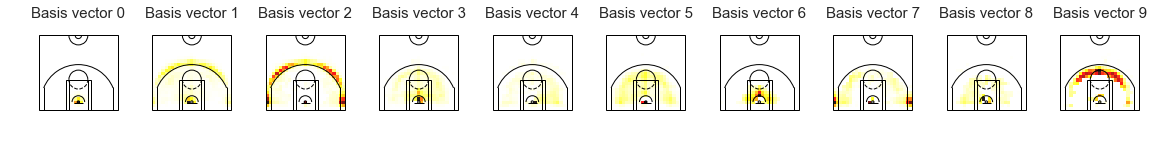

In [19]:
plt.figure(figsize=(20,14))
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.hot_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

The weird thing is that each basis vector is not normalized. Since each basis is a spatial probability distribution, they should sum to one.

In [20]:
[np.sum(H[i,:]) for i in range(n_comp)]

[6.9258792466832855,
 7.0328544558113837,
 7.051631392987459,
 4.750843736730376,
 3.362088759867925,
 6.4239888148766564,
 3.7941052857520008,
 3.8308078349493915,
 2.2717704452558727,
 3.076827616139505]

And the sum of the weights for each player also do not add to one.

In [21]:
df_W = pd.DataFrame(W, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
df_W[:3]

,Basis 0,Basis 1,Basis 2,Basis 3,Basis 4,Basis 5,Basis 6,Basis 7,Basis 8,Basis 9
Kevin Durant,0.028524,0.064243,1.447122e-07,0.000000,0.037011,0.035198,0.0,0.000000,0.000000,0.0
Carmelo Anthony,0.016731,0.038711,1.550143e-02,0.000000,0.047906,0.049937,0.0,0.000000,0.009090,0.0
DeMar DeRozan,0.013682,0.013756,7.262644e-03,0.037866,0.041898,0.035665,0.0,0.042245,0.020051,0.0


We can easily fix this by normalizing each basis and adjusting the weights to account for this normalization.

Now the basis vectors are normalized and the weights sum to (approximately) one.

In [22]:
W_norm = np.copy(W)
H_norm = np.copy(H)
for i in range(n_comp):
    temp = np.sum(H[i,:])
    W_norm[:,i] *= temp
    H_norm[i,:] *= 1./temp
[np.sum(W_norm[i,:]) for i in range(20)]

[0.99991496301524263,
 0.99994622421963397,
 0.99997232236152411,
 0.99997952281857883,
 1.0000062526144626,
 1.0000040989685823,
 1.000020256713734,
 0.99993190161212253,
 1.0000862716164605,
 0.99997131393655825,
 0.99989894853705219,
 0.99993197160796876,
 1.0000033276556142,
 0.9998927923387797,
 0.99990753740463356,
 1.0000314296620978,
 1.0000797511093467,
 0.99999050142171386,
 0.99993247071484692,
 0.99999355217805719]

Now, I will show you the normalized weights of each basis vector for each player. You can see from the table how players differ from each other.

------------------------
Summary of the basis vectors:

In [23]:
def color_df_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for large weights , 
    black otherwise.
    """
    if (float(val) > 0.20):
        color = 'red'
    else: 
        color = 'black'
    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

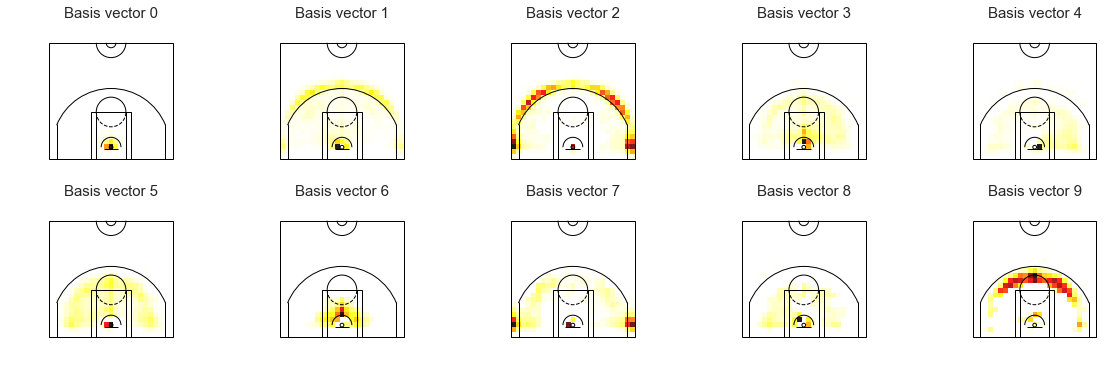

In [24]:
plt.figure(figsize=(20,6))
for i in range(n_comp):
    plt.subplot(2, np.ceil(n_comp/2.), i+1)

    extent = np.max(xedges), np.min(xedges), np.max(yedges), np.min(yedges)

    plt.imshow(H_norm[i,:].reshape(bins[0],bins[1]).T, cmap=plt.cm.hot_r, alpha=.9,
               extent=extent)
    plot_court.draw_court(outer_lines=True, lw=1.)

    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('Basis vector %d'%(i), fontsize=15)
    plt.axis('off')
plt.show()

In [25]:
df_W_norm = pd.DataFrame(W_norm, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
for column in ['Basis %d'%i for i in range(n_comp)]:
    df_W_norm[column] = df_W_norm[column].map('{:,.4f}'.format)
    
df_W_norm.style.applymap(color_df_red)  

What I would like to do here is provide some radar charts to graphically visualize the table shown above.

## Radar plots to visualize a player's shot profile

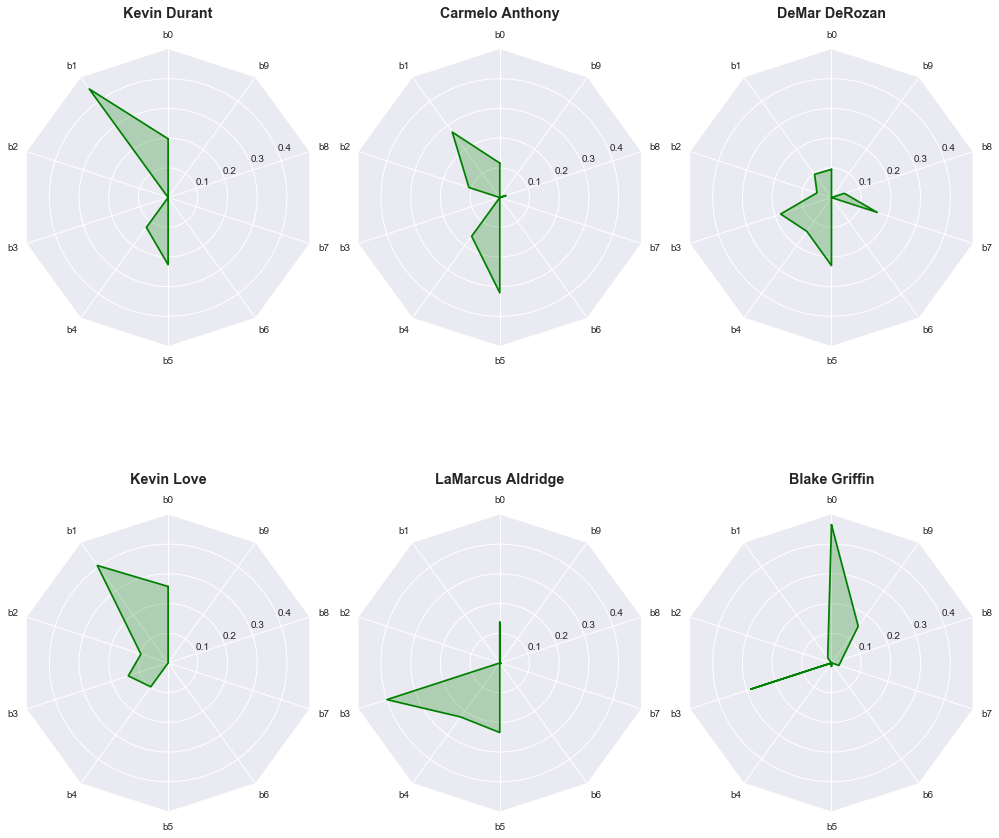

In [26]:
theta = radar_plot.radar_factory(n_comp, frame='polygon')
spoke_labels = ['b%d'%i for i in range(n_comp)]

fig, axes = plt.subplots(figsize=(14, 14), nrows=2, ncols=3,
                         subplot_kw=dict(projection='radar'))

for i, ax in enumerate(axes.flatten()):
    ax.set_rgrids([0.1, 0.2, 0.3, 0.4])
    ax.set_ylim(0, 0.5)
    player_name = df_W_norm.index.values[i]
    dat = np.array(df_W_norm.loc[player_name], dtype='float')
    ax.set_title(player_name, weight='bold', size='large', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    color = 'green'
    ax.plot(theta, dat, color=color)
    ax.fill(theta, dat, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

plt.tight_layout()
plt.show()

# CLUSTERING PLAYERS based on of SHOT PROFILES

## Two-dimensional projections

We now have changed each player's shot profile into 10 weights of their corresponding basis vectors (or factors). This kind of data is often visualized by projecting the data onto the various two-dimensional planes. Clearly defined clusters can sometimes be qualitatively found by just inspecting these plots. However, we can see that is not quite the case here.

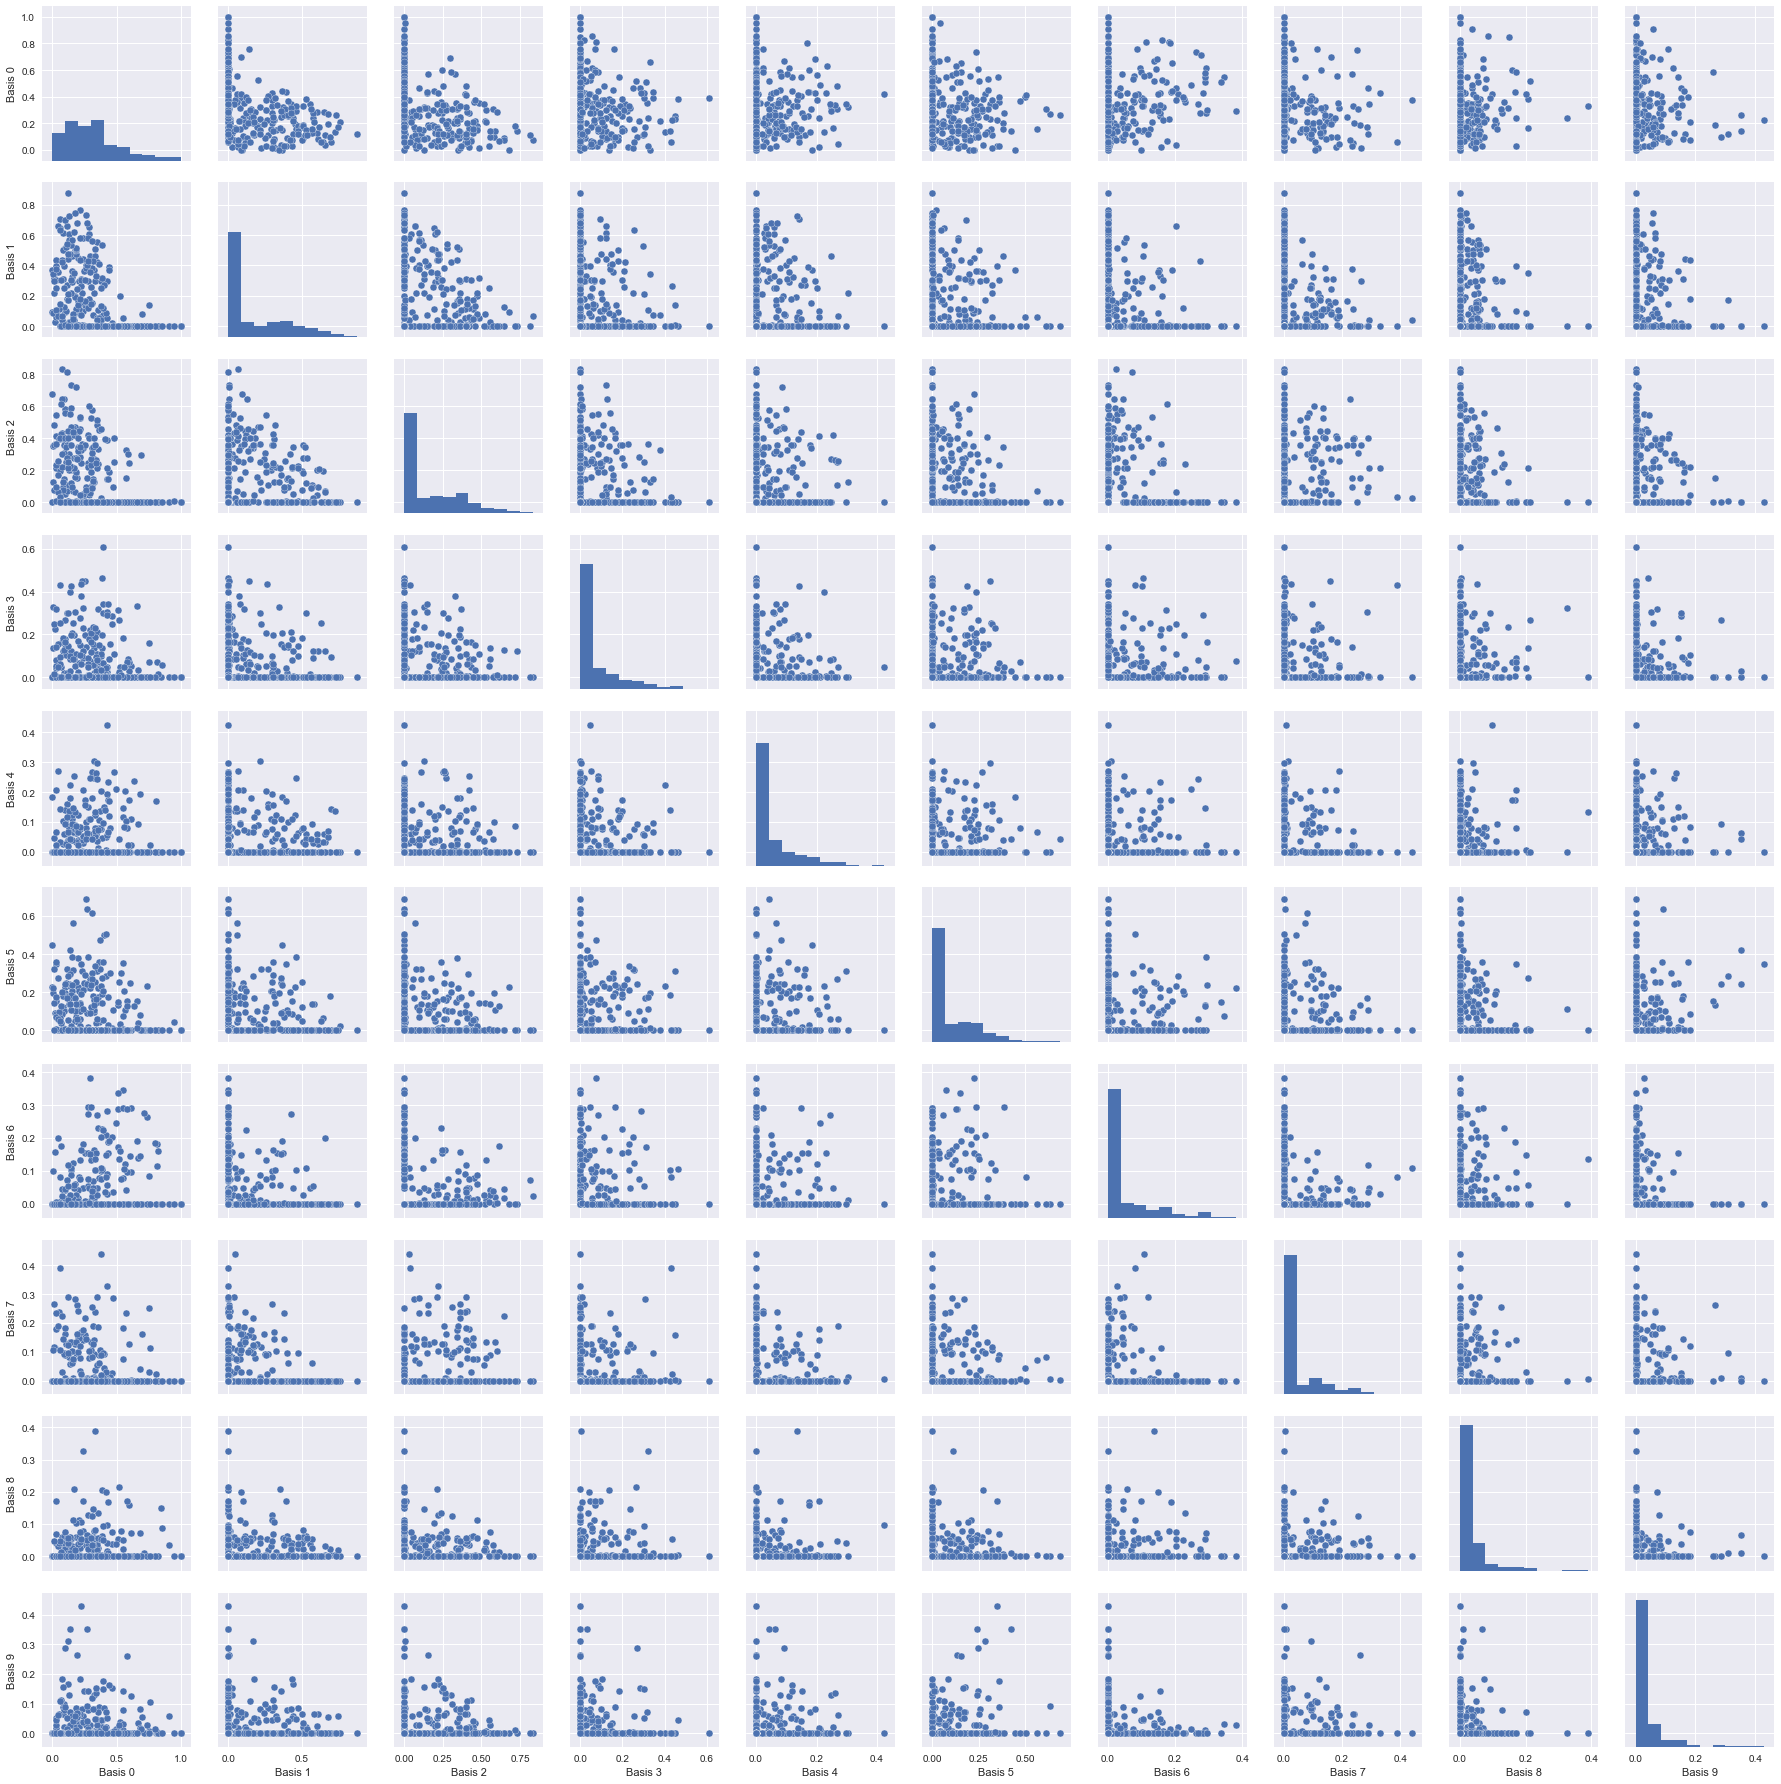

In [27]:
df_W_norm = pd.DataFrame(W_norm, index=top_players_nameList, columns = ['Basis %d'%i for i in range(n_comp)])
sns.pairplot(df_W_norm, vars=['Basis %d'%i for i in range(n_comp)])
plt.show()

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

I will use a custom distance metric: the Jensen–Shannon (JS) divergence. The JS divergence is a symmetrized version of the Kullback–Leibler (KL) divergence. 

The JS divergence compares two distributions and finds out how similar they are. If the JS divergence is 0, then the two distributions are identical. If the JS divergence is 1, then the two distributions behave in such a different manner that the likelihood that the first distribution describes the second approaches zero.

In [64]:
def divergence_kl(p, q):
    return np.sum(p * np.log(p/q))

def divergence_js(p,q):
    m = 0.5 * (p + q)
    return 0.5 * (divergence_kl(p, m) + divergence_kl(q, m))

def calc_divergenceJS_matrix(LL):
    num_players = LL.shape[0]
    num_bins = LL.shape[1]
    divergence_matrix = np.zeros((num_players,num_players))
    LL_i = np.zeros(num_bins)
    LL_j = np.zeros(num_bins)
    for i in np.arange(0, num_players):
        LL_i[:] = LL[i,:]
        divergence_matrix[i,i] = divergence_js(LL_i, LL_i)
        for j in np.arange(i, num_players):
            LL_j[:] = LL[j,:]
            temp = divergence_js(LL_i, LL_j)
            divergence_matrix[i,j] = temp
            divergence_matrix[j,i] = temp
    return divergence_matrix

def calc_divergenceKL_matrix(LL):
    num_players = LL.shape[0]
    num_bins = LL.shape[1]
    divergence_matrix = np.zeros((num_players,num_players))
    LL_i = np.zeros(num_bins)
    LL_j = np.zeros(num_bins)
    for i in np.arange(0, num_players):
        LL_i[:] = LL[i,:]
        divergence_matrix[i,i] = divergence_kl(LL_i, LL_i)
        for j in np.arange(0, num_players):
            LL_j[:] = LL[j,:]
            divergence_matrix[i,j] = divergence_kl(LL_i, LL_j)
    return divergence_matrix

In [101]:
p = np.array(LL[df_W_norm.index.values == 'DeAndre Jordan',:], dtype='float')
q = np.array(LL[df_W_norm.index.values == 'Andre Drummond'], dtype='float')
divergence_js(p,q)

0.078708901732208555

In [65]:
LL = np.zeros((num_players,np.prod(bins)))
for i, player in enumerate(top_players_nameList):
    norm_lambdaN_v = np.loadtxt('player_lambda/norm_lambda_%s.txt'%(player))
    LL[i,:] = norm_lambdaN_v[:]
X = calc_divergenceJS_matrix(LL)
Y = calc_divergenceKL_matrix(LL)

In [69]:
print(X)
print(Y)
Y[Y>0].min()

[[ 0.          0.08820471  0.13905082 ...,  0.22343386  0.28619998
   0.25752545]
 [ 0.08820471  0.          0.09942923 ...,  0.2459891   0.31067986
   0.31938932]
 [ 0.13905082  0.09942923  0.         ...,  0.27523817  0.28683168
   0.28907782]
 ..., 
 [ 0.22343386  0.2459891   0.27523817 ...,  0.          0.27363342
   0.32838449]
 [ 0.28619998  0.31067986  0.28683168 ...,  0.27363342  0.          0.14199382]
 [ 0.25752545  0.31938932  0.28907782 ...,  0.32838449  0.14199382  0.        ]]
[[ 0.          0.40422843  0.66752686 ...,  1.55141154  2.74212241
   2.40042895]
 [ 0.41526533  0.          0.4613799  ...,  1.86505622  2.69707706
   2.82720849]
 [ 0.71404405  0.45766379  0.         ...,  2.15701654  2.34199714
   2.58438572]
 ..., 
 [ 1.09966008  1.20499895  1.34773355 ...,  0.          3.00527044
   3.37095418]
 [ 1.1263278   1.27810922  1.11582413 ...,  1.19179777  0.          0.73023769]
 [ 1.01544753  1.4208607   1.18557716 ...,  1.78367829  0.98680844  0.        ]]


0.18203260130443585

In [30]:
#db_clust = DBSCAN(eps=0.085, min_samples=1, metric='precomputed').fit(X)
for i in np.arange(2,20):
    km_clust = KMeans(n_clusters=i).fit(X)
    labels = km_clust.labels_
    print('Estimated number of clusters: %d' % i)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels, metric="precomputed"))


#print(km_clust.labels_)
#print(np.bincount(km_clust.labels_))

Estimated number of clusters: 2
Silhouette Coefficient: 0.349
Estimated number of clusters: 3
Silhouette Coefficient: 0.158
Estimated number of clusters: 4
Silhouette Coefficient: 0.096
Estimated number of clusters: 5
Silhouette Coefficient: 0.099
Estimated number of clusters: 6
Silhouette Coefficient: 0.071
Estimated number of clusters: 7
Silhouette Coefficient: 0.056
Estimated number of clusters: 8
Silhouette Coefficient: 0.060
Estimated number of clusters: 9
Silhouette Coefficient: 0.047
Estimated number of clusters: 10
Silhouette Coefficient: 0.046
Estimated number of clusters: 11
Silhouette Coefficient: 0.038
Estimated number of clusters: 12
Silhouette Coefficient: 0.030
Estimated number of clusters: 13
Silhouette Coefficient: 0.031
Estimated number of clusters: 14
Silhouette Coefficient: 0.029
Estimated number of clusters: 15
Silhouette Coefficient: 0.022
Estimated number of clusters: 16
Silhouette Coefficient: 0.028
Estimated number of clusters: 17
Silhouette Coefficient: 0.024


In [79]:
#db_clust = DBSCAN(eps=0.2, min_samples=10).fit(W_norm)
db_clust = DBSCAN(eps=0.4, min_samples=2, metric='precomputed').fit(Y)
print(db_clust.labels_)
print(len(db_clust.labels_[db_clust.labels_==-1]))
print(np.bincount(db_clust.labels_[db_clust.labels_>-1]))

[ 0  1 16 -1 -1  2  2  0  3  0  4  5  6 -1  6  0  0  0  5 -1  0  2  2  7  4
  0 -1  8  0  6  9 10  6  6 11  0 -1 12  2  6  2  0 -1 12  6 13  2  2 -1 14
  2  2 15  6 -1 16  0  2 10  6  2  6  2 -1  4 23 17 18 19  2 -1 20 21 22 39
 12  2  6 -1  0  2 23 23 24  6 25  2 -1  0  6 -1  2 23  2  2  2 -1 -1 -1 26
  2 27 28 23 29 -1  2  0 -1  0 23 -1 -1 -1 30  2 -1 -1  2 -1 -1 -1  6 31 -1
 -1  2 -1 -1 -1  2 22 -1 -1 11 32  6 -1 33 -1 -1 34 -1 -1 35 -1 -1  2 -1 36
  0 22 -1 -1 37 23  2 -1 -1 -1 -1 23 38 -1 -1 -1 -1  2 -1 23 -1 -1  6 -1 -1
 24 39 -1 -1 -1 -1  2 40 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 41 -1 -1 -1 -1
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 42 -1 -1 23 -1 -1  2 -1 23 -1 23 -1 -1 -1
 -1 -1 -1 -1 -1 23 -1 -1 -1 -1 43 -1 -1 -1 -1 -1 -1 23 23 -1 -1 -1 -1 -1 -1
 -1 -1 -1 23 -1 -1 -1 -1 44 -1 -1 -1  2 -1 -1 23 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 45 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 23  2]
158
[17  1 37  1  3  2 16  1  1  1  2  2  3  1  1  1  2  1  1  1  1  1  3 18  2
  1  1 

In [95]:
temp = 0.5*(Y+Y.T)
km_clust = KMeans(n_clusters=10, precompute_distances=True).fit(temp)
print(km_clust.labels_)
print("Silhouette Coefficient: %0.5f"
          % metrics.silhouette_score(temp, labels, metric="precomputed"))

[0 0 8 0 1 4 1 3 0 0 0 0 4 8 4 3 0 0 0 1 0 1 4 0 0 0 0 0 0 4 3 0 4 0 5 0 0
 3 4 4 1 3 3 3 0 0 1 1 3 0 5 1 0 0 4 8 3 1 3 4 1 3 1 0 8 4 0 4 0 1 2 4 0 3
 4 3 5 0 8 3 5 7 6 4 0 0 5 2 0 4 3 5 6 4 1 5 2 3 3 3 1 3 4 4 3 4 1 3 8 3 6
 3 3 0 0 5 0 3 1 3 4 3 0 0 3 4 1 0 3 3 5 3 3 3 5 3 0 3 0 0 0 3 3 4 1 7 7 1
 9 4 0 2 3 0 7 5 1 0 3 1 2 5 3 2 3 3 2 5 3 6 2 1 4 8 2 0 4 0 8 3 3 1 7 0 2
 3 4 5 4 3 1 5 0 3 0 1 0 2 4 2 4 4 3 8 7 4 8 3 3 3 1 1 1 2 5 4 3 1 3 5 3 6
 2 2 3 2 4 4 1 3 6 0 0 1 2 5 7 1 1 3 2 1 5 6 3 2 4 7 9 5 3 1 9 6 2 7 1 2 5
 8 2 2 5 1 4 5 9 5 6 3 2 4 3 3 7 3 2 5 8 3 5 2 1 7 2 3 7 1 5 8 3 4 5 5 2 7
 7 2 5 5]
Silhouette Coefficient: -0.00040


In [32]:
df_W_norm.index.values[km_clust.labels_==0]

array(['Kevin Durant', 'Kevin Love', 'Paul George', 'Kyrie Irving',
       'James Harden', 'Jeff Green', 'Brandon Jennings', 'Goran Dragic',
       'Brandon Knight', 'Isaiah Thomas', 'Gordon Hayward', 'Mike Conley',
       'Chandler Parsons', 'Spencer Hawes', 'Lance Stephenson',
       'Eric Gordon', 'Ty Lawson', 'Jimmy Butler', 'Harrison Barnes',
       'Jeremy Lin', 'Jose Juan Barea', 'Kawhi Leonard', 'Mike Scott',
       'Courtney Lee', 'Raymond Felton', 'Eric Bledsoe', 'Norris Cole',
       'Shelvin Mack', 'Patrick Patterson', 'Draymond Green',
       "E'Twaun Moore"], dtype=object)

In [33]:
km_clust = KMeans(n_clusters=10).fit(W_norm)
print(km_clust.labels_)
print(len(km_clust.labels_[km_clust.labels_==-1]))
print(np.bincount(km_clust.labels_[km_clust.labels_>-1]))

[2 2 4 2 9 9 6 0 1 7 2 0 2 2 2 5 1 6 0 8 7 9 2 4 2 5 2 1 0 2 0 2 2 2 3 4 4
 5 4 2 6 7 4 5 0 1 6 6 7 6 9 6 2 2 6 6 7 9 0 1 8 7 9 1 2 3 2 6 4 8 7 6 4 5
 2 5 8 0 4 7 8 3 3 3 2 2 3 0 0 3 7 8 3 6 8 8 7 0 5 4 6 1 9 3 0 1 9 0 4 7 3
 5 0 2 2 8 4 7 9 7 1 7 0 0 7 9 8 1 4 0 3 4 1 1 8 0 2 7 4 5 0 0 7 8 6 4 1 9
 5 2 7 5 0 1 1 8 9 2 0 6 5 3 1 5 7 0 1 9 4 3 7 6 2 2 5 1 3 2 4 7 4 8 1 4 5
 5 2 8 2 7 6 8 7 1 4 6 1 4 9 7 9 9 0 4 1 3 6 5 7 7 8 3 6 4 8 9 0 6 1 3 7 3
 5 5 7 7 9 2 6 7 3 2 2 3 1 3 1 9 6 7 7 6 3 3 4 4 2 1 5 6 4 6 5 3 4 2 3 5 8
 4 7 5 8 6 8 3 5 8 3 4 5 6 4 5 1 0 7 9 2 0 9 5 3 8 4 0 3 8 9 1 0 8 8 8 5 1
 1 1 3 8]
0
[29 31 38 30 32 28 28 34 28 22]


In [63]:
for i in np.arange(2,20):
    km_clust = KMeans(n_clusters=i).fit(W_norm)
    labels = km_clust.labels_
    print('Estimated number of clusters: %d' % i)
    print(labels)
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(W_norm, labels))
    print('---------------------')

Estimated number of clusters: 2
[0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0
 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 0
 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1
 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1
 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1
 1 0 1 1]
Silhouette Coefficient: 0.250
---------------------
Estimated number of clusters: 3
[1 1 0 1 2 2 2 1 2 1 1 1 1 1 1 0 0 0 1 2 1 2 1 0 1 0 1 0 1 1 1 1 1 1 2 0 0
 0 2 1 2 1 0 0 1 0 2 2 0 0 2 2 1 1 2 2 1 2 1 0 2 1 2 0 1 2 1 2 2 2 1 2 0 0
 1 0 2 1 0 1 2 2 2 2 1 1 2 1 1 2 1 2 2 2 2 2 0 1 0 0 2 0 2 2 1 2 2 1 1 1 2
 0 1 1 1 2 0 0 2 0 2 1 1 1 1 2 2 0 0 1 2 0 0 0 2 

Estimated number of clusters: 13
[ 8  8  9  3 10 10  4  0  1  8  8  0  3  8  8  9  1  9  0 11  5 10  8  9  8
  1  3  1  0  3  0  0  3  3  2  9  9 12  6  3  4  5  9 12  3  1  4  4  5  9
 10  4  3  3  4  4  5 10  0  1  6  5 10  1  8  2  3  4  9  6  5  4  9  7  3
 12 11  0  9  5  6  2  2  6  8  3  2  0  0  6  5 11  2  4 11  6  5  0 12  7
  4  1 10  2  0  1 10  5  8  5  2  7  0  8  3  6  9  5 10  7  1  8  0  0  5
 10 11  1  9  0  2  7  1  1 11  0  3  8  9  1  0  0  5 11  4  6  7 10 12  3
  8 12  0  1  1 11  6  3  0  4 12  2  1  7  9  0  7 10  9  2  5  4  3  8 12
  7  6  5 10  5  7 11  1  9 12  7  3  6  3  8  4 11  5  7  9  4  7  7 10  5
 10 10  0 10  1  2  8 12  5  5 11 11  4  7 11 10  0  4  1  2  5  2 12 12  5
  7 10  3  4  5  2  3  3  2  7  6  1 10 11  7  5  4  2  2  9  9  3  1 12  4
  7  4 12  2  7  3  2 12  6  3  5 12 11  4  6  2 12 11  2  7  7  6  9  7  7
  0  5 10  8  0 10 12  2  6  7  0  2 11  2  1  0 11 11  6 12  7  1  1  2 11]
Silhouette Coefficient: 0.202
---------------------
Es

In [34]:
df_W_norm.index.values[km_clust.labels_==6]

array(['Al Jefferson', 'Kyrie Irving', 'Anthony Davis', 'Serge Ibaka',
       'Carlos Boozer', 'Chris Bosh', 'David West', 'Tony Parker',
       'Gerald Henderson', 'Rodney Stuckey', 'Markieff Morris',
       'Dwyane Wade', 'Brandon Bass', 'Nene', 'Luis Scola',
       'Dante Cunningham', 'Kris Humphries', 'Anderson Varejao',
       'Darrell Arthur', 'Al Horford', "Kyle O'Quinn", 'Kevin Garnett',
       'Jeremy Evans', 'Elton Brand', 'Robert Sacre', 'Lavoy Allen',
       'Jason Smith', 'Cory Joseph'], dtype=object)

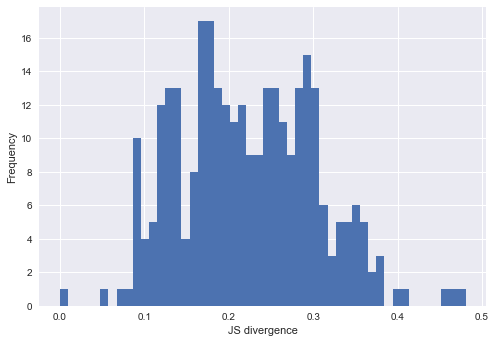

In [124]:
#temp = X[X>0].flatten()
temp = X[100,:]
plt.hist(temp,50)
plt.xlabel('JS divergence')
plt.ylabel('Frequency')
plt.show()

In [118]:
X.max()

0.61211543132786905

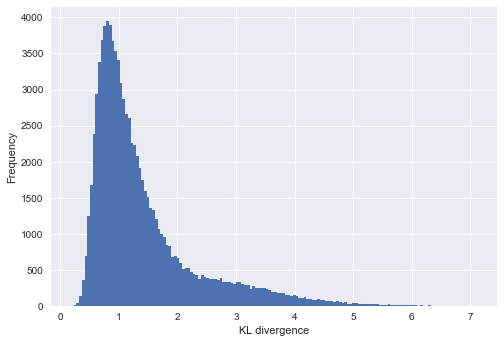

In [74]:
plt.hist(Y[Y>0].flatten(),150)
plt.xlabel('KL divergence')
plt.ylabel('Frequency')
plt.show()

In [36]:
LL.shape[0]

300

# STUFF I am TRYING

In [37]:
print(set(full_DatFrame.ACTION_TYPE))

{'Alley Oop Dunk Shot', 'Driving Bank Hook Shot', 'Reverse Layup Shot', 'Driving Bank shot', 'Floating Jump shot', 'Jump Hook Shot', 'Running Dunk Shot', 'Putback Reverse Dunk Shot', 'Jump Bank Shot', 'Hook Shot', 'Driving Reverse Layup Shot', 'Tip Shot', 'Layup Shot', 'Pullup Bank shot', 'Running Reverse Layup Shot', 'Running Bank Hook Shot', 'Fadeaway Bank shot', 'Alley Oop Layup shot', 'Jump Bank Hook Shot', 'Driving Slam Dunk Shot', 'Turnaround Hook Shot', 'Turnaround Bank Hook Shot', 'Running Layup Shot', 'Driving Finger Roll Layup Shot', 'Reverse Slam Dunk Shot', 'Hook Bank Shot', 'Running Hook Shot', 'Driving Layup Shot', 'Reverse Dunk Shot', 'Running Bank shot', 'Running Slam Dunk Shot', 'Jump Shot', 'Driving Hook Shot', 'Dunk Shot', 'Putback Layup Shot', 'Fadeaway Jump Shot', 'Finger Roll Layup Shot', 'Running Finger Roll Layup Shot', 'Pullup Jump shot', 'Driving Dunk Shot', 'Turnaround Fadeaway shot', 'Putback Slam Dunk Shot', 'Step Back Jump shot', 'Putback Dunk Shot', 'Turn